In [1]:
import logging
import yaml
import asyncio

import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle

from lsst.ts import salobj
from lsst.ts.standardscripts.auxtel import ATTCS

import SALPY_ATPtg


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# attcs = ATTCS()

In [ ]:
# attcs.log.setLevel(logging.DEBUG)

In [ ]:
for c in attcs.components():
    r = getattr(attcs, c.lower())
    state_topic = await r.evt_summaryState.next(flush=False, timeout=5.)
    state = salobj.State(state_topic.summaryState)
    print(f"{c}::{state!r}")

In [32]:
state_topic = await attcs.atpneumatics.evt_summaryState.next(flush=False, timeout=5.)
state = salobj.State(state_topic.summaryState)
print(f"{attcs.atpneumatics.salinfo.name}::{state!r}")

ATPneumatics::<State.ENABLED: 2>


In [33]:
await attcs.atpneumatics.cmd_start.start(timeout=300)

CommandIdAck(cmd_id=1559838819, ack=(ack=303, error=0, result='Ok'))

In [34]:
await attcs.atpneumatics.cmd_enable.start(timeout=300)

CommandIdAck(cmd_id=1559838819, ack=(ack=303, error=0, result='Ok'))

In [35]:
await attcs.atpneumatics.cmd_openMasterAirSupply.start(timeout=300)

CommandIdAck(cmd_id=1559838819, ack=(ack=303, error=0, result='Ok'))

In [36]:
await attcs.atpneumatics.cmd_openInstrumentAirValve.start(timeout=300)

CommandIdAck(cmd_id=1559838819, ack=(ack=303, error=0, result='Ok'))

In [ ]:
await attcs.atpneumatics.cmd_m1OpenAirValve.start()

In [ ]:
attcs.atpneumatics.cmd_m1SetPressure.set(pressure=0.1)

In [ ]:
await attcs.atpneumatics.cmd_m1SetPressure.start()

In [ ]:
await attcs.atpneumatics.cmd_m1CloseAirValve.start()

# Measure maximum load on cell at a specified altitude

In [8]:
class MeasureM1Pressure():
    
    def __init__(self, attcs):
        
        self.attcs = attcs
        self.elevation = np.array([])
        self.pressure = np.array([])
        self.load_off = np.array([])
        self.max_load = np.array([])
        self.min_load = np.array([])
        
        self.min_allowed_load = 120.
        self.optimum_fraction = 1./3.
        self.tolerance = 0.01
        
    async def get_load(self, n=10):
        
        load_measures = np.zeros(n)
        for i in range(n):
            load = await self.attcs.atpneumatics.tel_loadCell.next(flush=True, timeout=2)
            load_measures[i] = load.cellLoad
            
        return np.mean(load_measures)
    
    async def get_pressure(self, n=10):
        
        pressure_measures = np.zeros(n)
        for i in range(n):
            topic = await self.attcs.atpneumatics.tel_m1AirPressure.next(flush=True, timeout=3)
            pressure_measures[i] = topic.pressure
            
        return np.mean(pressure_measures)*u.Pa    

    async def measure_optimum_pressure(self):
        
        attcs = self.attcs
        
        encoders = attcs.atmcs.tel_mountEncoders.get()
        
        await attcs.atpneumatics.cmd_m1CloseAirValve.start()
        await asyncio.sleep(5.)
        
        closed_air_load = await self.get_load()
        
        optimum_load = closed_air_load * self.optimum_fraction

        print(f"Optimum load: {optimum_load}")
        
        await attcs.atpneumatics.cmd_m1OpenAirValve.start()    

        attcs.atpneumatics.cmd_m1SetPressure.set(pressure=0.1)
        self.attcs.atpneumatics.evt_m1SetPressure.flush()
        await attcs.atpneumatics.cmd_m1SetPressure.start()
        try:
            sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass

        min_pressure = await self.get_pressure()

        print(f"Minimum pressure: {min_pressure}")

#         max_pressure = 15.*np.sin(np.radians(encoders.elevationCalculatedAngle))*u.imperial.psi
        max_pressure = 9. * np.sin(np.radians(encoders.elevationCalculatedAngle)) * min_pressure

        print(f"Maximum pressure: {max_pressure.to(u.Pa)}")

        print(f"Max/Min pressure: {max_pressure.to(u.Pa)/min_pressure}")

        max_load = await self.get_load()  # Max load is with minumum pressure 

        print(f"Max load: {max_load}")
        
#         if max_load > optimum_load:
#             print(f"Max load larger then optimum. Operation complete.")
#             self.elevation = np.append(self.elevation, encoders.elevationCalculatedAngle)
#             self.pressure = np.append(self.pressure, min_pressure)
#             return 

        attcs.atpneumatics.cmd_m1SetPressure.set(pressure=max_pressure.to(u.Pa).value)
        self.attcs.atpneumatics.evt_m1SetPressure.flush()
        await attcs.atpneumatics.cmd_m1SetPressure.start()
        try:
            sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=120)
        except asyncio.TimeoutError:
            pass

        measured_pressure = await self.get_pressure()

        min_load = await self.get_load()
        
        if min_load < self.min_allowed_load:
#             attcs.atpneumatics.cmd_m1SetPressure.set(pressure=0.1)
#             await attcs.atpneumatics.cmd_m1SetPressure.start()
            print(f"Min load {min_load} to small {self.min_allowed_load}. ")
#             return 
            
        print(f"Min load: {min_load}")

        init_pressure = (min_pressure+max_pressure.to(u.Pa))/2.
        print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

        attcs.atpneumatics.cmd_m1SetPressure.set(pressure=init_pressure.to(u.Pa).value)
        self.attcs.atpneumatics.evt_m1SetPressure.flush()
        await attcs.atpneumatics.cmd_m1SetPressure.start()
        try:
            sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass

        niter = 0
        max_iter = 11
        success = True

        init_pressure = (min_pressure+max_pressure.to(u.Pa))/2.
        print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

        attcs.atpneumatics.cmd_m1SetPressure.set(pressure=init_pressure.to(u.Pa).value)
        self.attcs.atpneumatics.evt_m1SetPressure.flush()
        await attcs.atpneumatics.cmd_m1SetPressure.start()
        try:
            sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=30)
        except asyncio.TimeoutError:
            pass

        load = await self.get_load()
        
        print("****")
        print(f"load: {load}")
        print(f"Optimum load: {optimum_load}")
        delta = np.abs(load - optimum_load)/optimum_load
        print(f"{delta} > 0.1")
        print("****")

        
        while delta > self.tolerance:
            niter += 1
            print(f"Iter {niter}")
            print(f"Dif: {load-optimum_load}")

            if load - optimum_load < 0.:
                max_pressure = init_pressure
            else:
                min_pressure = init_pressure
            init_pressure = (min_pressure+max_pressure)/2.
            print(f"Init pressure: {init_pressure} ({init_pressure/max_pressure.to(u.Pa)})")

            attcs.atpneumatics.cmd_m1SetPressure.set(pressure=init_pressure.to(u.Pa).value)
            self.attcs.atpneumatics.evt_m1SetPressure.flush()
            await attcs.atpneumatics.cmd_m1SetPressure.start()
            try:
                sp = await self.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=30)
            except asyncio.TimeoutError:
                pass
            
            measured_pressure = await self.get_pressure()
            
            print(f"Set pressure: {init_pressure.to(u.Pa)}")
            print(f"Measured pressure: {measured_pressure}")
            print(f"Diff: {init_pressure.to(u.Pa).value-measured_pressure.to(u.Pa).value}")

            load = await self.get_load()

            print("****")
            print(f"load: {load}")
            print(f"Optimum load: {optimum_load}")
            delta = np.abs(load - optimum_load)/optimum_load
            print(f"diff: {delta} | tol: {self.tolerance}")
            print("****")
            
            

            if niter > max_iter:
                print("Failed")
                success = False
                break

        if success:
            print("Success!")
            optimum_pressure = await self.get_pressure()
            print(f"Optimum pressure: {optimum_pressure} @ el {encoders.elevationCalculatedAngle}")        
            self.elevation = np.append(self.elevation, encoders.elevationCalculatedAngle)
            self.pressure = np.append(self.pressure, optimum_pressure.to(u.Pa).value)    
            
        attcs.atpneumatics.cmd_m1SetPressure.set(pressure=0.1)
        await attcs.atpneumatics.cmd_m1SetPressure.start()



In [3]:
attcs = ATTCS()

In [9]:
mp = MeasureM1Pressure(attcs)

In [39]:
await mp.measure_optimum_pressure()

Optimum load: 361.41357628479005
Minimum pressure: 10443.347872314454 Pa
Maximum pressure: 93762.99485855806 Pa
Max/Min pressure: 8.978250653425595
Max load: 1006.4701832611084
Min load: 360.1384416046143
Init pressure: 52103.171365436254 Pa (0.555690136007645)
Init pressure: 52103.171365436254 Pa (0.555690136007645)
****
load: 658.5688263702392
Optimum load: 361.41357628479005
0.8222027881190993 > 0.1
****
Iter 1
Dif: 297.15525008544915
Init pressure: 72933.08311199716 Pa (0.7778450680038226)
Set pressure: 72933.08311199716 Pa
Measured pressure: 72475.3571459961 Pa
Diff: 457.72596600106044
****
load: 515.0611965454102
Optimum load: 361.41357628479005
0.42512963082368405 > 0.1
****
Iter 2
Dif: 153.64762026062016
Init pressure: 83348.03898527761 Pa (0.8889225340019113)
Set pressure: 83348.03898527761 Pa
Measured pressure: 82703.66459106446 Pa
Diff: 644.374394213155
****
load: 440.341607510376
Optimum load: 361.41357628479005
0.21838701256587958 > 0.1
****
Iter 3
Dif: 78.92803122558593
I

In [41]:
await mp.measure_optimum_pressure()

Optimum load: 340.8718262817383
Minimum pressure: 10133.832736816406 Pa
Maximum pressure: 88496.71213435139 Pa
Max/Min pressure: 8.73279779059715
Max load: 941.0208867004394
Min load: 337.19144731750487
Init pressure: 49315.272435583895 Pa (0.5572554193958738)
Init pressure: 49315.272435583895 Pa (0.5572554193958738)
****
load: 630.7009344085694
Optimum load: 340.8718262817383
0.850258325213656 > 0.1
****
Iter 1
Dif: 289.8291081268311
Init pressure: 68905.99228496764 Pa (0.7786277096979368)
Set pressure: 68905.99228496764 Pa
Measured pressure: 68440.08775878907 Pa
Diff: 465.904526178565
****
load: 495.61313019104
Optimum load: 340.8718262817383
0.4539574466955344 > 0.1
****
Iter 2
Dif: 154.74130390930168
Init pressure: 78701.35220965951 Pa (0.8893138548489684)
Set pressure: 78701.35220965951 Pa
Measured pressure: 78184.23862548829 Pa
Diff: 517.1135841712239
****
load: 421.68088478393554
Optimum load: 340.8718262817383
0.23706581850330655 > 0.1
****
Iter 3
Dif: 80.80905850219722
Init pr

In [43]:
await mp.measure_optimum_pressure()

Optimum load: 315.00215814819336
Minimum pressure: 10033.67692138672 Pa
Maximum pressure: 82496.51681951978 Pa
Max/Min pressure: 8.22196264299471
Max load: 863.1661767883301
Min load: 323.1984505645752
Init pressure: 46265.09687045325 Pa (0.5608127306958772)
Init pressure: 46265.09687045325 Pa (0.5608127306958772)
****
load: 581.0928558929444
Optimum load: 315.00215814819336
0.8447265863479201 > 0.1
****
Iter 1
Dif: 266.090697744751
Init pressure: 64380.80684498651 Pa (0.7804063653479386)
Set pressure: 64380.80684498651 Pa
Measured pressure: 63811.66869995118 Pa
Diff: 569.1381450353292
****
load: 463.9714187713624
Optimum load: 315.00215814819336
0.4729150476267091 > 0.1
****
Iter 2
Dif: 148.96926062316902
Init pressure: 73438.66183225314 Pa (0.8902031826739693)
Set pressure: 73438.66183225314 Pa
Measured pressure: 73053.14678710936 Pa
Diff: 385.5150451437803
****
load: 391.06407756958004
Optimum load: 315.00215814819336
0.2414647565227258 > 0.1
****
Iter 3
Dif: 76.06191942138668
Init 

In [45]:
await mp.measure_optimum_pressure()

Optimum load: 283.19121309814443
Minimum pressure: 10532.56229614258 Pa
Maximum pressure: 78588.11744115068 Pa
Max/Min pressure: 7.461443401092686
Max load: 762.055643838501
Min load: 257.692139465332
Init pressure: 44560.33986864663 Pa (0.5670111630045707)
Init pressure: 44560.33986864663 Pa (0.5670111630045707)
****
load: 510.55569050903324
Optimum load: 283.19121309814443
0.8028655794913101 > 0.1
****
Iter 1
Dif: 227.3644774108888
Init pressure: 61574.22865489866 Pa (0.7835055815022853)
Set pressure: 61574.22865489866 Pa
Measured pressure: 60883.16315551758 Pa
Diff: 691.0654993810822
****
load: 389.04141893920894
Optimum load: 283.19121309814443
0.37377644836875795 > 0.1
****
Iter 2
Dif: 105.85020584106451
Init pressure: 70081.17304802468 Pa (0.8917527907511428)
Set pressure: 70081.17304802468 Pa
Measured pressure: 69547.06201293945 Pa
Diff: 534.111035085225
****
load: 326.74692684631344
Optimum load: 283.19121309814443
0.15380319633389927 > 0.1
****
Iter 3
Dif: 43.55571374816901
In

In [49]:
await mp.measure_optimum_pressure()

Optimum load: 242.87831435546877
Minimum pressure: 10164.552797851564 Pa
Maximum pressure: 65805.89636806751 Pa
Max/Min pressure: 6.474057214005185
Max load: 653.8379771575928
Min load: 236.19901591186527
Init pressure: 37985.224582959534 Pa (0.5772313224106764)
Init pressure: 37985.224582959534 Pa (0.5772313224106764)
****
load: 438.3949682647705
Optimum load: 242.87831435546877
0.8049983977702923 > 0.1
****
Iter 1
Dif: 195.51665390930174
Init pressure: 51895.56047551352 Pa (0.7886156612053382)
Set pressure: 51895.56047551352 Pa
Measured pressure: 51600.44443847657 Pa
Diff: 295.11603703695437
****
load: 340.2057516723633
Optimum load: 242.87831435546877
0.4007251020955674 > 0.1
****
Iter 2
Dif: 97.32743731689453
Init pressure: 58850.72842179051 Pa (0.894307830602669)
Set pressure: 58850.72842179051 Pa
Measured pressure: 58324.771223144526 Pa
Diff: 525.957198645985
****
load: 289.79132468261724
Optimum load: 242.87831435546877
0.19315438042149832 > 0.1
****
Iter 3
Dif: 46.9130103271484

In [53]:
await mp.measure_optimum_pressure()

Optimum load: 195.00035558776852
Minimum pressure: 9763.508713378907 Pa
Maximum pressure: 51649.90412577084 Pa
Max/Min pressure: 5.290096587407673
Max load: 511.5262951538087
Min load: 200.2554218078613
Init pressure: 30706.70641957487 Pa (0.594516232688488)
Init pressure: 30706.70641957487 Pa (0.594516232688488)
****
load: 349.3151816986084
Optimum load: 195.00035558776852
0.7913566395594785 > 0.1
****
Iter 1
Dif: 154.31482611083987
Init pressure: 41178.30527267286 Pa (0.797258116344244)
Set pressure: 41178.30527267286 Pa
Measured pressure: 40918.91088745117 Pa
Diff: 259.3943852216835
****
load: 276.2544442382812
Optimum load: 195.00035558776852
0.41668687426542 > 0.1
****
Iter 2
Dif: 81.2540886505127
Init pressure: 46414.10469922185 Pa (0.898629058172122)
Set pressure: 46414.10469922185 Pa
Measured pressure: 46054.63177612305 Pa
Diff: 359.4729230987941
****
load: 235.9037620513916
Optimum load: 195.00035558776852
0.20976067628355008 > 0.1
****
Iter 3
Dif: 40.90340646362307
Init press

In [56]:
await mp.measure_optimum_pressure()

Optimum load: 139.89037409973142
Minimum pressure: 9933.521105957032 Pa
Maximum pressure: 39191.30904914442 Pa
Max/Min pressure: 3.9453592166469345
Max load: 341.8150548980713
Min load: 127.33654194946288
Init pressure: 24562.41507755073 Pa (0.6267311726370351)
Init pressure: 24562.41507755073 Pa (0.6267311726370351)
****
load: 220.81391417541505
Optimum load: 139.89037409973142
0.5784782591116039 > 0.1
****
Iter 1
Dif: 80.92354007568363
Init pressure: 31876.862063347577 Pa (0.8133655863185175)
Set pressure: 31876.862063347577 Pa
Measured pressure: 31553.92132202148 Pa
Diff: 322.94074132609603
****
load: 180.60441084594726
Optimum load: 139.89037409973142
0.29104244668893203 > 0.1
****
Iter 2
Dif: 40.71403674621584
Init pressure: 35534.085556246 Pa (0.9066827931592587)
Set pressure: 35534.085556246 Pa
Measured pressure: 34955.22123046876 Pa
Diff: 578.8643257772419
****
load: 154.57795273132325
Optimum load: 139.89037409973142
0.1049934902677484 > 0.1
****
Iter 3
Dif: 14.687578631591833

In [57]:
mp.elevation, mp.pressure

(array([86.24835172, 76.0056504 , 86.01592981, 76.00358599, 66.00083777,
        56.00119823, 45.99999094, 36.0002307 , 26.00013384]),
 array([87299.2594751 , 88051.26973633, 87883.5718689 , 85399.45515259,
        79528.9777356 , 74007.15197021, 61774.46574829, 50110.10065552,
        36839.87593384]))

In [60]:
data = np.array([mp.elevation[2:], mp.pressure[2:]])

In [61]:
data

array([[8.60159298e+01, 7.60035860e+01, 6.60008378e+01, 5.60011982e+01,
        4.59999909e+01, 3.60002307e+01, 2.60001338e+01],
       [8.78835719e+04, 8.53994552e+04, 7.95289777e+04, 7.40071520e+04,
        6.17744657e+04, 5.01101007e+04, 3.68398759e+04]])

In [62]:
np.save("alt_pressure.npy", data)

In [65]:
fit = np.polyfit(mp.elevation[2:], mp.pressure[2:], 2)

Text(0,0.5,'Pressure (kPa)')

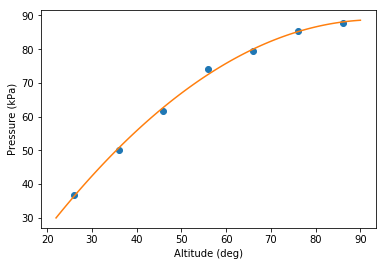

In [74]:
poly = np.poly1d(fit)
x = np.linspace(22., 90., 100)
y = poly(x)
plt.plot(mp.elevation[2:], mp.pressure[2:]/1e3, 'o')
plt.plot(x, y/1e3, '-')
plt.xlabel("Altitude (deg)")
plt.ylabel("Pressure (kPa)")

In [75]:
print(fit)

[-1.14681512e+01  2.14676757e+03 -1.17336994e+04]


In [23]:
ss = attcs.atdome.evt_summaryState.get()
print(ss)

In [24]:
salobj.State(ss.summaryState)

<State.STANDBY: 5>

In [25]:
await salobj.set_summary_state(attcs.atdome, salobj.State.ENABLED, settingsToApply='test')

In [20]:
await salobj.set_summary_state(attcs.atdome, salobj.State.STANDBY)

In [76]:
attcs.atdome.cmd_moveAzimuth.set(azimuth=0.)

True

In [77]:
await attcs.atdome.cmd_moveAzimuth.start()

CommandIdAck(cmd_id=1559838822, ack=(ack=303, error=0, result='Done'))

In [28]:
await attcs.atdome.cmd_openShutter.start()

CommandIdAck(cmd_id=1559838820, ack=(ack=303, error=0, result='Done'))

In [31]:
await attcs.atdome.cmd_closeShutter.start()

CommandIdAck(cmd_id=1559838819, ack=(ack=303, error=0, result='Done'))

In [ ]:
await mp.attcs.atpneumatics.evt_m

In [ ]:
sp = await mp.attcs.atpneumatics.evt_m1SetPressure.next(flush=False, timeout=5)

In [ ]:
sp.pressure

In [ ]:
await mp.attcs.atpneumatics.cmd_m1CloseAirValve.start()    

In [ ]:
mp.attcs.atpneumatics.cmd_m1SetPressure.set(pressure=0.1)
await mp.attcs.atpneumatics.cmd_m1SetPressure.start()

In [ ]:
pressure = 15.*u.imperial.psi
mp.attcs.atpneumatics.cmd_m1SetPressure.set(pressure=pressure.to(u.Pa).value)
await mp.attcs.atpneumatics.cmd_m1SetPressure.start()

In [ ]:
load = await mp.get_load()

In [ ]:
print(load)

In [ ]:
load2 = await mp.get_load()

In [ ]:
print(load2/3.)

In [ ]:
mp.min_allowed_load = load

In [ ]:
mp.min_allowed_load

## Get the optimum pressure for a specified load

Set the optimum load. Measure the minimum pressure and load and get maximum pressure to run a search for the best pressure. 

In [ ]:
optimum_pressure = await get_pressure(10, attcs.atpneumatics.tel_m1AirPressure)
print(f"Optimum pressure: {optimum_pressure}")

In [ ]:
for c in attcs.components():
    r = getattr(attcs, c.lower())
    await salobj.set_summary_state(r, salobj.State.STANDBY)